## Lab #3 - Automatic Clipping

In this lab, we will explore a few example methods on how to detect important moments of the game from the media analysis, and perform an automatic clipping of the highlights. For this purpose we will:
- Use AWS managed AI Services for transcribing the narration of the game from the video's audio.
- Use AWS managed AI Services for analyzing the transcription for detecting specific keywords.
- Analyze the audio of the video for identifying patterns during high-intensity plays such as scoring a goal.
- Use AWS managed AI Services for identifying the score, by extracting text from the video, and recognizing people such as celebrities or pre-defined players.
- Combine all this information with the activity classification from the previous lab for marking highlights.
- Create a sample video clipping workflow.

### Setup

In [81]:
import boto3
import time
import urllib.request
import json
import pandas as pd
import datetime as dt
import re
import math

region = boto3.Session().region_name
#media = 's3://rodzanto2020ml/sports/football2_in/Football2.mp4'
media = 's3://rodzanto2020ml/sports/football1/full-match-real-madrid-vs-atletico-de-madrid-laliga-20172018.mp4'
split_media = 's3://rodzanto2020ml/sports/football4/'
#job_name = 'football2-transcription'
job_name = 'football1-transcription'

print('region: {}'.format(region))
print('media: {}'.format(media))
print('transcribe-job: {}'.format(job_name))


region: eu-west-1
media: s3://rodzanto2020ml/sports/football1/full-match-real-madrid-vs-atletico-de-madrid-laliga-20172018.mp4
transcribe-job: football1-transcription


### Transcribe audio from video recordings

We will automatically transcribe the narration of a game with Amazon Transcribe.

In [30]:
transcribe = boto3.client('transcribe', region_name=region)

In [4]:
transcribe.start_transcription_job(TranscriptionJobName=job_name, Media={'MediaFileUri': media}, MediaFormat='mp4', LanguageCode='es-ES')

In [31]:
while True:
    status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
    if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
        break
    print("Not ready yet...")
    time.sleep(2)
print(status)

{'TranscriptionJob': {'TranscriptionJobName': 'football1-transcription', 'TranscriptionJobStatus': 'COMPLETED', 'LanguageCode': 'es-ES', 'MediaSampleRateHertz': 44100, 'MediaFormat': 'mp4', 'Media': {'MediaFileUri': 's3://rodzanto2020ml/sports/football1/full-match-real-madrid-vs-atletico-de-madrid-laliga-20172018.mp4'}, 'Transcript': {'TranscriptFileUri': 'https://s3.eu-west-1.amazonaws.com/aws-transcribe-eu-west-1-prod/889960878219/football1-transcription/6988109e-f224-45a2-8130-bb408232b747/asrOutput.json?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEGsaCWV1LXdlc3QtMSJHMEUCIGCSncVApdM4SIsuKbdmjpicNCVNJItG90sqlG3lFA85AiEAgevwR7s6S57XYz2YyKf6GfLUPyG2w0wDFpWrob2QmIwqtAMIZBACGgw1ODcwMTc2NjM0MTciDGN1CMdzuog%2BPv%2BX8CqRA%2FSqxbPHiyrS0m1Pa3X2QC%2FrwQWKX0Z4zVFzVnqr7tZhHBGEeIxdehUdyiofOgEmF4AjhKYvhkIPm4mvPEmP%2ByHDPynlRKaKzd0a3yL5fqQmhw8%2F%2Fqp%2FhYVAIhLHfCC9I0AB9sZcHQYGLNWODfsTsCQd5h7RvmeIu5b%2B8LKJbjV%2BeqN5Cc8K3kpQryeZmvkuK8ucWyNQCMkVfJI0%2B6r42eLWLDO%2FSsBXeeZTbyEaQxNtZE9GaRjXm%2FKYwjdnnCNsrhYc

#### Mark keywords in transcriptions

We can highlight a few keywords in the narration, in example: goal, card, shoot, foul, yellow, red.

In [32]:
if status['TranscriptionJob']['TranscriptionJobStatus'] == 'COMPLETED':
    response = urllib.request.urlopen(status['TranscriptionJob']['Transcript']['TranscriptFileUri'])
    data = json.loads(response.read())
    text = data['results']['transcripts'][0]['transcript']
    search_words = ["gol", "tarjeta", "falta", "disparo", "amarilla", "roja"]
    for i, s in enumerate(search_words):
        if (search_words[i] in text):
            text = re.sub(r'\b'+search_words[i]+r'\b', '\033[44;33m{}\033[m'.format(search_words[i]), text)
    print(text)

Qué tal amigos? Sólo dos Bienvenidos a Madrid. Bienvenidos al estadio Santiago Bernabéu. Bienvenidos a la Liga Santander en bien la Liga. Lo que hoy nos ocupa no es un partido más. No es un partido cualquiera. Es el derbi de la capital. Real Madrid Atlético de Madrid, tercero contra segundo clasificado. Con la prevalencia, la supremacía del fútbol capitalino en juego en noventa minutos de puro fútbol que compartimos desde ya con Rubén, Uría, Jorge, Valdano ya, excepto reciben ellos todos. Buenas tardes. Hola, qué tal? Efectivamente, partido de estos tan marcado en el calendario partido entre dos equipos que no solamente se juegan cosas de la tabla de clasificación, sino que se juega buena parte de su honor contra Jackie. Felicita muchísima historia. Así que una gran tarde de fútbol l- Si, evidentemente también en estado de ánimo para para reforzarlo o para matizar lo no. Los dos equipos probablemente tienen ahora mismo el gran objetivo en en Europa. Pero acabar por encima del vecino de

We can also visualize these keywords in the timeline, for identifying important sections of the media.

In [33]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

def format_func(x, pos):
    hours = int(x//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)
formatter = FuncFormatter(format_func)

def plot_timeline(data):
    cats = {}
    colormapping = {}
    for i, s in enumerate(data):
        if data[i][2] not in cats:
            cats[data[i][2]] = len(cats)+1
            colormapping[data[i][2]] = 'C' + str(len(cats)-1)
    print(cats)
    print(colormapping)
    
    verts = []
    colors = []
    for d in data:
        v =  [(d[0], cats[d[2]]-.2),
              (d[0], cats[d[2]]+.2),
              (d[1], cats[d[2]]+.2),
              (d[1], cats[d[2]]-.2),
              (d[0], cats[d[2]]-.2)]
        verts.append(v)
        colors.append(colormapping[d[2]])
    
    bars = PolyCollection(verts, facecolors=colors)
    
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax.xaxis.set_major_formatter(formatter)
    ax.add_collection(bars)
    ax.autoscale()
    
    ax.set_yticks(list(cats.values()))
    ax.set_yticklabels(list(cats))
    
    plt.grid(b=True,which='both')
    plt.show()


In [34]:
trans = data['results']['items']
keywords = []
for i, j in enumerate(trans):
    if (trans[i]['alternatives'][0]['content'] in search_words):
        keywords.append([trans[i]['start_time'], trans[i]['end_time'], trans[i]['alternatives'][0]['content']])
        #print(trans[i]['start_time'],trans[i]['start_time'],trans[i]['alternatives'][0]['content'])
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.DataFrame(keywords)

,0,1,2
0,823.21,823.6,falta
1,933.5,933.7,falta
2,978.75,979.01,falta
3,988.85,989.1,falta
4,1002.17,1002.43,falta
5,1174.97,1178.16,falta
6,1397.39,1397.69,falta
7,1407.13,1407.69,tarjeta
8,1512.03,1512.34,falta
9,1512.4,1512.81,tarjeta


{'falta': 1, 'tarjeta': 2, 'amarilla': 3, 'gol': 4, 'disparo': 5}
{'falta': 'C0', 'tarjeta': 'C1', 'amarilla': 'C2', 'gol': 'C3', 'disparo': 'C4'}


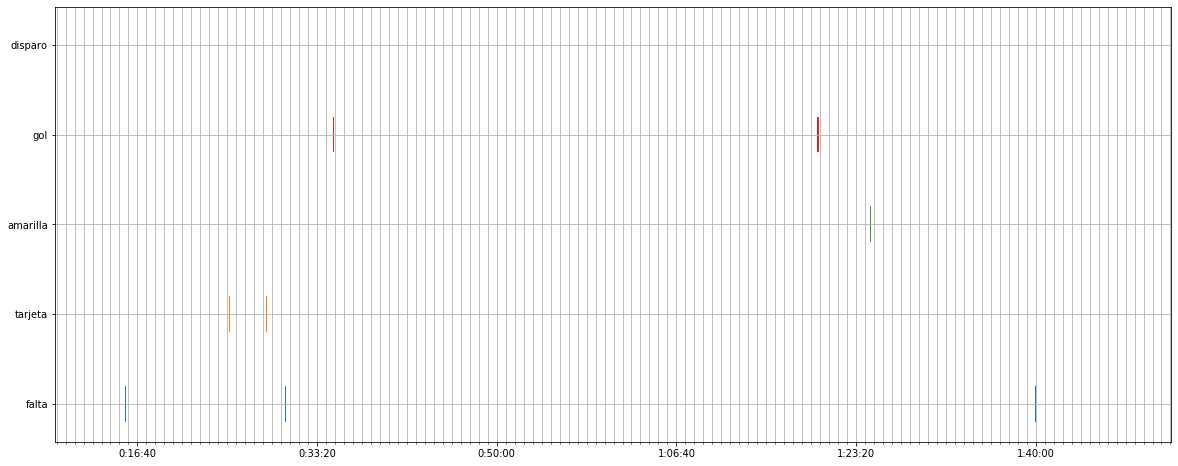

In [35]:
plot_timeline(keywords)

## Analyzing audio from media

Another way to analyze the audio of the video is by looking at the actual sound waves.

In [10]:
#conda install -c conda-forge librosa

In [69]:
import librosa
audio_data = '../sample_media/Football2.mp4'
x , sr = librosa.load(audio_data)
print(type(x), type(sr)) #<class 'numpy.ndarray'> <class 'int'>print(x.shape, sr)#(94316,) 22050

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


<class 'numpy.ndarray'> <class 'int'>


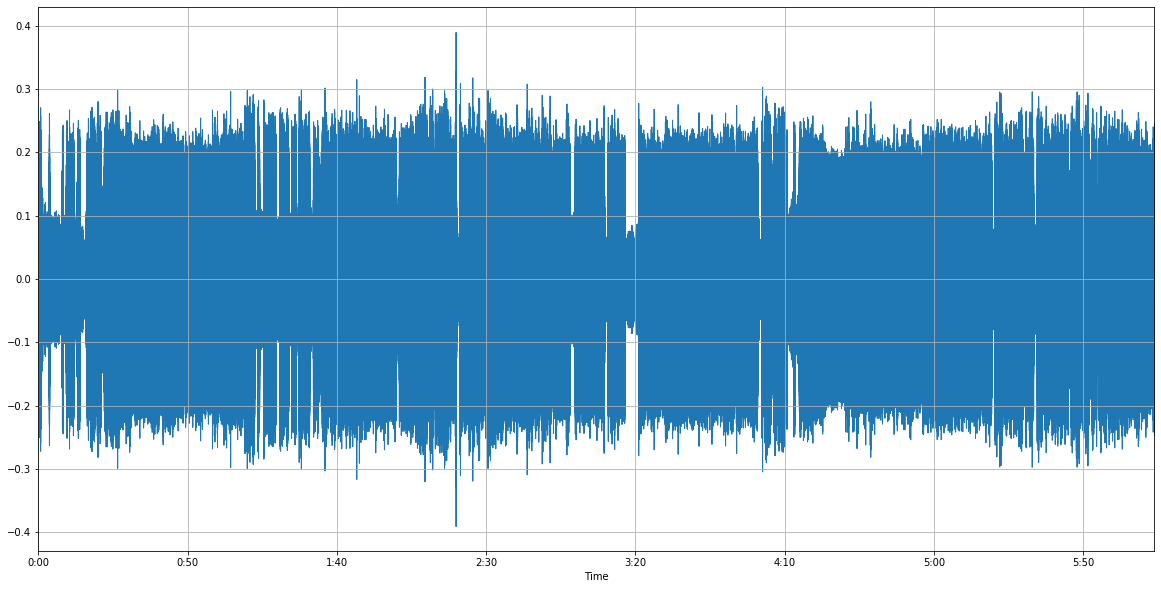

In [13]:
import librosa.display
plt.figure(figsize=(20, 10))
plt.grid(b=True,which='both')
librosa.display.waveplot(x, sr=sr)

(1025, 16103)


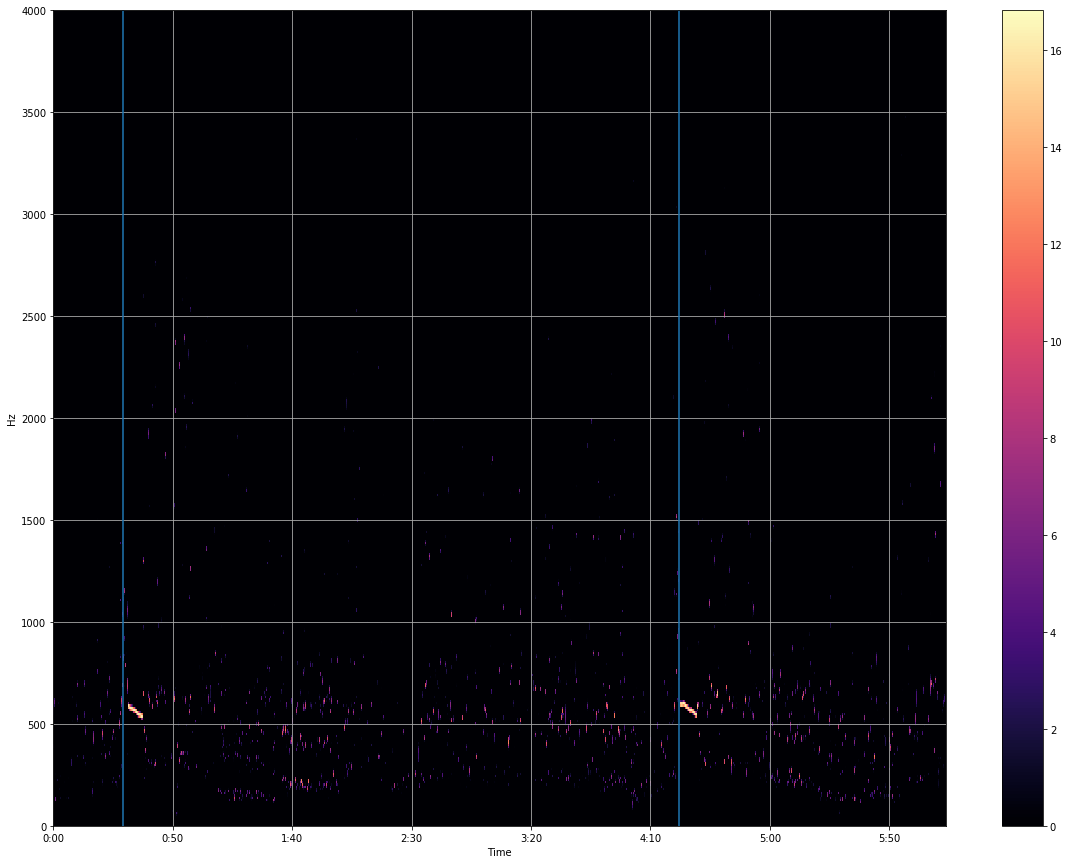

In [14]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X), amin=10, top_db=4000)
print(Xdb.shape)
plt.figure(figsize=(20, 15))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.grid(b=True,which='both')
plt.axvline((29), 0, 1, label='gol-RM')
plt.axvline(((4*60)+22), 0, 1, label='gol-AT')
plt.ylim((0,4000))
plt.colorbar()

We can observe the two regions where the goals were scored, and how the waves show a particular behavior.

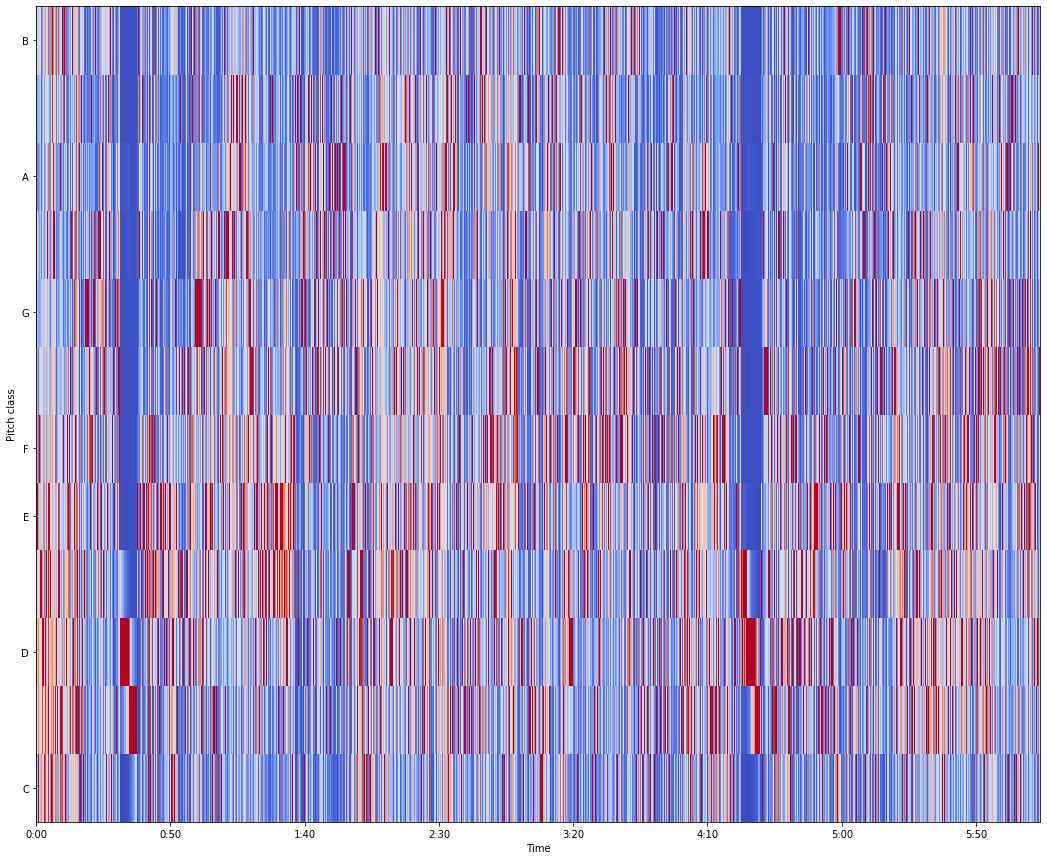

In [24]:
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=5000)
plt.figure(figsize=(18, 15))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=5000, cmap='coolwarm')

## Extracting text and celebrities from images

### Text extraction

We can also detect the text from the score shown in the corner of the screen in the video, and detect when there is a change in the score.

In [49]:
bucket = 'rodzanto2020ml'
prefix_document = 'sports/football2_in/Football2.mp4/frame_'
team = 'RMA '

client = boto3.client('textract')

def get_text(bucket, document):
    response = client.detect_document_text(Document={'S3Object': {'Bucket': bucket, 'Name': document}})
    blocks=response['Blocks']
    for i, j in enumerate(blocks):
        if (blocks[i]['BlockType'] == 'LINE'):
            if ('RMA ' in blocks[i]['Text']):
                return blocks[i]['Text'], document

for k in range(0, 186):
    score=get_text(bucket,(prefix_document + str(k).zfill(4) + '.jpeg'))
    if score:
        print(score)

('52:25 RMA 0 0 ATM', 'sports/football2_in/Football2.mp4/frame_0000.jpeg')
('52:31 RMA 0 0 ATM', 'sports/football2_in/Football2.mp4/frame_0003.jpeg')
('RMA 0 0 ATM', 'sports/football2_in/Football2.mp4/frame_0004.jpeg')
('52:37 RMA 0 0 ATM', 'sports/football2_in/Football2.mp4/frame_0006.jpeg')
('52:39 RMA 0 0 ATM', 'sports/football2_in/Football2.mp4/frame_0007.jpeg')
('52:41 RMA 0 0 ATM', 'sports/football2_in/Football2.mp4/frame_0008.jpeg')
('52:43 RMA 0 0 ATM', 'sports/football2_in/Football2.mp4/frame_0009.jpeg')
('52:45 RMA 0 0 ATM', 'sports/football2_in/Football2.mp4/frame_0010.jpeg')
('52:51 RMA 0 0 ATM', 'sports/football2_in/Football2.mp4/frame_0013.jpeg')
('52:53 RMA 0 0 ATM', 'sports/football2_in/Football2.mp4/frame_0014.jpeg')
('52:55 RMA 0 0 ATM', 'sports/football2_in/Football2.mp4/frame_0015.jpeg')
('52:57 RMA 1 0 ATM', 'sports/football2_in/Football2.mp4/frame_0016.jpeg')
('52:59 RMA 1 0 ATM', 'sports/football2_in/Football2.mp4/frame_0017.jpeg')
('53:03 RMA 1 0 ATM', 'sports/f

We can also recognize celebrities from the video.

Here note you could also have a pre-created collection of players with their image, so that we could detect all of the people in the field. https://docs.aws.amazon.com/rekognition/latest/dg/collections.html

In [61]:
client = boto3.client('rekognition')

def get_celebrities(bucket, document):
    response = client.recognize_celebrities(Image={'S3Object': {'Bucket': bucket, 'Name': document}})
    blocks=response['CelebrityFaces']
    for i, j in enumerate(blocks):
        return blocks[i]['Name'], document
    
for k in range(19, 20):
    celeb=get_celebrities(bucket,(prefix_document + str(k).zfill(4) + '.jpeg'))
    if celeb:
        print(celeb)

('Marcelo Vieira', 'sports/football2_in/Football2.mp4/frame_0019.jpeg')


## Mark relevant actions for highlights (based on activity detection and/or manual labeling)

Now we can map the video files that correspond to the marked times, for both the main and sample videos.

In [23]:
main_total_lenght = (1*3600)+(59*60)+6 ### The main video had a duration of 1:59:06 - With a small video extracted every 20 seconds
main_segments_freq = 20
print('Total video segments for main video:', math.ceil(main_total_lenght/main_segments_freq))
print('Total duration for main video (sec):', main_total_lenght)

Total video segments for main video: 358
Total duration for main video (sec): 7146


In [55]:
all_segments = []
for i in range(math.ceil(main_total_lenght/main_segments_freq)):
    all_segments.append(['Football4_{:03d}'.format(i), (i*main_segments_freq)])

main_segments = []
for j, k in enumerate(keywords):
    if keywords[j][2] == 'gol':
        main_segments.append(all_segments[math.ceil(float(keywords[j][0])/main_segments_freq)-1])

print(main_segments)

inputs_main = open('inputs_main.txt', 'w')
for i in main_segments:
    inputs_main.write('file \'{}.mp4\'\n'.format(i[0]))
inputs_main.close()

[['Football4_104', 2080], ['Football4_172', 3440], ['Football4_212', 4240], ['Football4_216', 4320], ['Football4_219', 4380], ['Football4_222', 4440], ['Football4_237', 4740], ['Football4_239', 4780], ['Football4_243', 4860]]


In [24]:
sample_total_lenght = (0*3600)+(6*60)+14 ### The sample video had a duration of 0:06:14 - With an image extracted every 60 frames (every 2 seconds)
sample_segments_freq = 2
print('Total image frames for sample video:', math.ceil(sample_total_lenght/sample_segments_freq))
print('Total duration for sample video (sec):', sample_total_lenght)

Total image frames for sample video: 187
Total duration for sample video (sec): 374


In [78]:
keyaudio = [29, 262]    

def sec_to_time(sec_time):
    ht = math.floor(sec_time/3600)
    mt = math.floor(sec_time/60)
    st = sec_time-((ht*3600)+(mt*60))
    return '{:02d}'.format(ht)+':{:02d}'.format(mt)+':{:02d}'.format(st)

for i, j in enumerate(keyaudio):
    start_time=sec_to_time(j)
    end_time=sec_to_time(j+10)
    print('Clipping from:',start_time,'to:',end_time)
    file = 'segment_part{}.mp4'.format(i+1)
    #print('ffmpeg -i {} -ss {} -t {} -async 1 -strict -2 {}'.format(audio_data,start_time,end_time,file))
    !ffmpeg -i $audio_data -ss $start_time -t $end_time -async 1 -strict -2 $file

inputs_sample = open('inputs_sample.txt', 'w')
for i in range(len(keyaudio)):
    inputs_sample.write('file \'segment_part{}.mp4\'\n'.format(i+1))
inputs_sample.close()


Clipping from: 00:00:29 to: 00:00:39
ffmpeg version 4.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1566210161358/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '

## Build clipping workflow based on the above

We can now stitch together the segments of videos marked as highlights.

In [ ]:
### This would be for building the main video highlight...
#s3 = boto3.resource('s3')
#for i in main_segments:
#    s3.Bucket(bucket).download_file('{}/{}'.format(split_media, i), '../sample_media/highlight/{}'.format(i))    
#!ffmpeg -f concat -i inputs_main.txt -c copy main_highlight.mp4

In [79]:
!ffmpeg -y -f concat -i inputs_sample.txt -c copy sample_highlight.mp4

ffmpeg version 4.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1566210161358/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55da21c1ec00] Auto-inserting h264_mp4toannexb bit

In [80]:
for i in range(len(keyaudio)):
    file = 'segment_part{}.mp4'.format(i+1)
    !rm -f $file

Good job!, this is the end of the labs.